In [49]:
%cd /content/drive/MyDrive/Fanshawe/INFO 6147 DL with Pytorch/Project

/content/drive/MyDrive/Fanshawe/INFO 6147 DL with Pytorch/Project


In [50]:
# install libraries
!pip install torchmetrics
!pip install torchcam

In [51]:
# import libraries
import os
import glob
import random
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

#### Data Preprocessing

In [52]:
# classification threshold
threshold = 0.5
batch_size = 64


# directories for training and validation data
train_data_dir = '/content/drive/MyDrive/Fanshawe/INFO 6147 DL with Pytorch/Project/train'
val_data_dir = '/content/drive/MyDrive/Fanshawe/INFO 6147 DL with Pytorch/Project/val'


# define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# train & val dataset
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_data_dir, transform=val_transform)


# define loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [53]:
# mapping from class names to labels
class_to_label = train_dataset.class_to_idx

# mapping from labels to class names for visualization
label_to_class = {value: key for key, value in class_to_label.items()}
label_to_class

{0: 'Normal', 1: 'Pneumonia'}

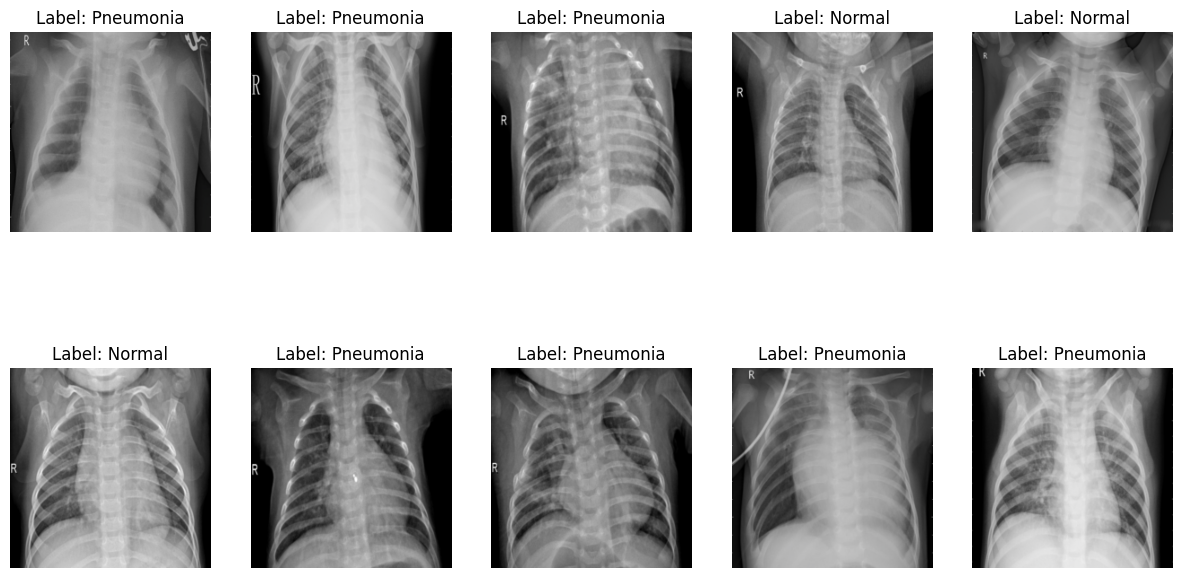

In [54]:
imgs, labels = next(iter(train_loader))


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Create subplots for displaying images
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i in range(imgs[:10].shape[0]):
    ax = axes[i//5, i%5]

    # Unnormalize
    unnormalized_img = np.transpose(imgs[i].numpy(), (1, 2, 0))
    unnormalized_img = np.clip((unnormalized_img * std) + mean, 0, 1)

    # plot
    ax.imshow(unnormalized_img)
    ax.set_title(f'Label: {label_to_class[labels[i].item()]}')
    ax.axis('off')

# display
plt.show()

#### Training Phase

In [55]:
# Set random seed for CPU
torch.manual_seed(50)

# Set random seed for GPU if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(50)

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
# Load pre-trained ResNet18 model
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')

# freeze parameters
for param in model.parameters():
    param.requires_grad = False


# modify the last FC layer
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# define loss + optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [57]:
# iteration count
iter_count = 1

# Initialize metrics
train_accuracy = Accuracy(task="binary").to(device)
val_accuracy = Accuracy(task="binary").to(device)

val_y_true = []
val_y_pred = []
batch_train_loss = []
val_loss_every_20 = []
val_precision_recall_f1 = {}

train_loss = 0.0
val_loss = 0.0
best_f1_score = -1.0
no_improvements = 0


# loop until f1 score does not increase
while no_improvements < 2:
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # forward pass
        output = model(imgs)
        loss = criterion(output.squeeze(), labels.float())

        # loss + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accumulate train loss
        train_loss += loss.item()
        batch_train_loss.append(loss.item())

        # update training accuracy
        train_accuracy.update(torch.sigmoid(output.squeeze()), labels)


        # evaluate model after every 20 iterations
        if iter_count % 20 == 0:
            print(f"Iteration: {iter_count}\n")

            # validation mode
            model.eval()
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)

                    # forward pass + loss
                    output = model(imgs)
                    loss = criterion(output.squeeze(), labels.float())
                    val_loss += loss.item()


                    # accumulate predictions + labels
                    val_y_true.append(labels)
                    predictions = torch.sigmoid(output)
                    val_y_pred.append((predictions > threshold).int())

                    # update validation accuracy
                    val_accuracy.update(torch.sigmoid(output.squeeze()), labels)


            # calculate and print accuracy using metrics
            train_acc = train_accuracy.compute().item()
            val_acc = val_accuracy.compute().item()
            print(f"Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

            # compute avg batch loss
            val_loss_every_20.append(val_loss/len(val_loader))
            print(f"Training loss: {torch.mean(torch.tensor(batch_train_loss))}\tValidation loss: {val_loss/len(val_loader)}")


            y_true = torch.cat(val_y_true, dim=0).cpu().numpy()
            y_pred = torch.cat(val_y_pred, dim=0).cpu().numpy()


            # calculate precision, recall & f1 score
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            print(f"Precision: {precision:.4f}\t Recall: {recall:.4f}\t F1 Score: {f1:.4f}")
            val_precision_recall_f1[iter_count] = [precision, recall, f1]
            print()


            # continue training only if f1 score is increasing
            if f1 > best_f1_score:
                best_f1_score = f1
                no_improvements = 0
            else:
                no_improvements += 1


            # reset metrics for next iteration
            val_y_true = []
            val_y_pred = []
            val_loss = 0.0
            train_loss = 0.0

            train_accuracy.reset()
            val_accuracy.reset()

            # save model
            torch.save(model.state_dict(), f'model_checkpoint_step{iter_count}.pth')

        iter_count += 1
        model.train()

print("Training complete!")

Iteration: 20

Training Accuracy: 0.4875, Validation Accuracy: 0.4872
Training loss: 0.7211582660675049	Validation loss: 0.7114891052246094
Precision: 0.5994	 Recall: 0.5410	 F1 Score: 0.5687

Iteration: 40

Training Accuracy: 0.6109, Validation Accuracy: 0.6074
Training loss: 0.6932602524757385	Validation loss: 0.6696963548660279
Precision: 0.6835	 Recall: 0.6923	 F1 Score: 0.6879

Iteration: 60

Training Accuracy: 0.6970, Validation Accuracy: 0.6795
Training loss: 0.6694128513336182	Validation loss: 0.6304805755615235
Precision: 0.7896	 Recall: 0.6641	 F1 Score: 0.7214

Iteration: 80

Training Accuracy: 0.7688, Validation Accuracy: 0.7788
Training loss: 0.6452425122261047	Validation loss: 0.5618372887372971
Precision: 0.8281	 Recall: 0.8154	 F1 Score: 0.8217

Iteration: 100

Training Accuracy: 0.8006, Validation Accuracy: 0.8029
Training loss: 0.626010537147522	Validation loss: 0.5296889334917069
Precision: 0.8560	 Recall: 0.8231	 F1 Score: 0.8392

Iteration: 120

Training Accuracy: 

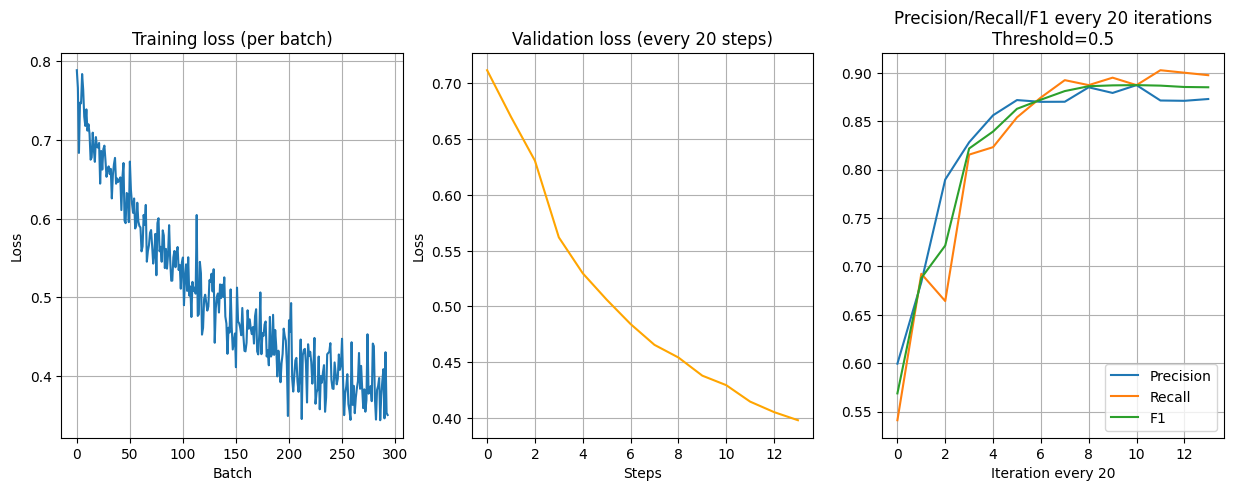

In [58]:
# unpack precision, recall & f1
precs, rec, f1 = zip(*val_precision_recall_f1.values())


# plot training loss
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(batch_train_loss)
axes[0].set_title('Training loss (per batch)')
axes[0].set_xlabel('Batch')
axes[0].set_ylabel('Loss')
axes[0].grid()

# plot validation loss
axes[1].plot(val_loss_every_20, color='orange')
axes[1].set_title('Validation loss (every 20 steps)')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Loss')
axes[1].grid()


# plot precision/recall/f1 on validation set
axes[2].plot(precs, label='Precision')
axes[2].plot(rec, label='Recall')
axes[2].plot(f1, label='F1')
axes[2].set_xlabel('Iteration every 20')
axes[2].set_title('Precision/Recall/F1 every 20 iterations\nThreshold=0.5')
axes[2].legend()
axes[2].grid()

#### Test Model

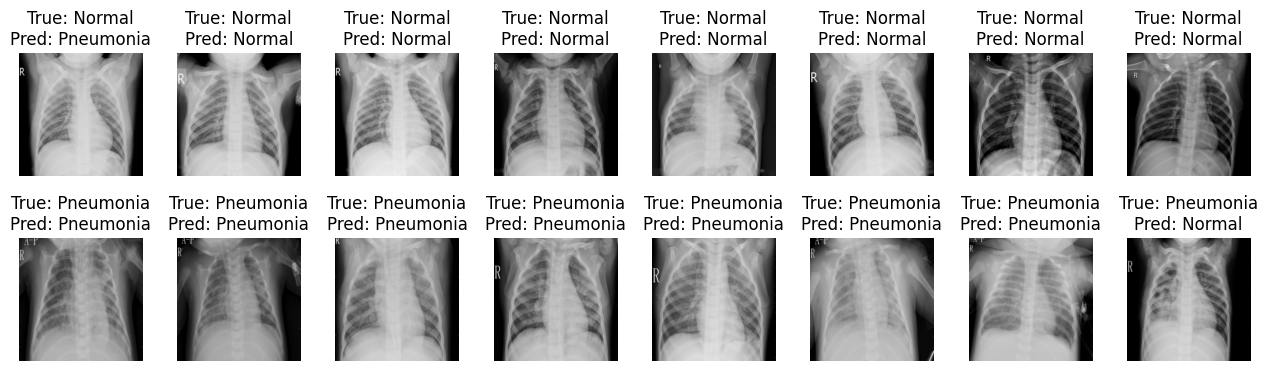

In [59]:
# test images path
test_data_dir = '/content/drive/MyDrive/Fanshawe/INFO 6147 DL with Pytorch/Project/test'

# apply transformation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)


# visualize images with their predictions
fig, axes = plt.subplots(2, 8, figsize=(16, 4), gridspec_kw={'hspace': 0.5})

# evaluation mode
model.eval()

for i, (img, label) in enumerate(test_dataset):

    # move to device
    img = img.to(device)

    # compute prediction
    output = model(img.unsqueeze(0))
    prediction = (torch.sigmoid(output.squeeze(0)) > threshold).int()

    # unnormalize
    ax = axes[i//8, i%8]
    img = np.clip((img.permute(1, 2, 0).cpu().numpy() * std) + mean, 0, 1)

    # plot
    ax.imshow(img)
    ax.set_title(f"True: {label_to_class[label]}\nPred: {label_to_class[prediction.item()]}")
    ax.axis('off')

plt.show()

#### Load fine-tuned weights for GRAD-CAM

In [60]:
# fine-tuned model weights path
model_path = '/content/drive/MyDrive/Fanshawe/INFO 6147 DL with Pytorch/Project'
model_checkpoint_path = os.path.join(model_path, 'model_checkpoint_step280.pth')


# load resnet18 model without pretrained weights
model_new = models.resnet18(weights=None).eval()

# load model with fine-tuned weights
model_new.fc = nn.Linear(model_new.fc.in_features, 1)
model_new.load_state_dict(torch.load(model_checkpoint_path, map_location=device))

<All keys matched successfully>

In [61]:
# load images for GRAD-CAM
cam_dir = '/content/drive/MyDrive/Fanshawe/INFO 6147 DL with Pytorch/Project/CAM'
cam_dataset = datasets.ImageFolder(root=cam_dir, transform=train_transform)

##### Grad-CAM

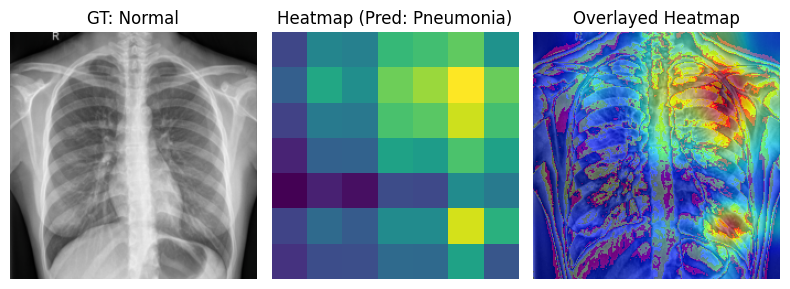

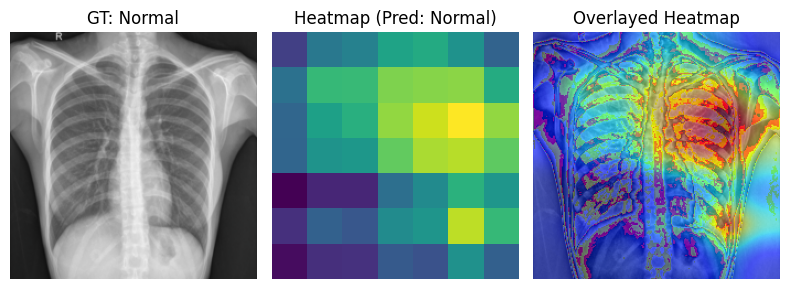

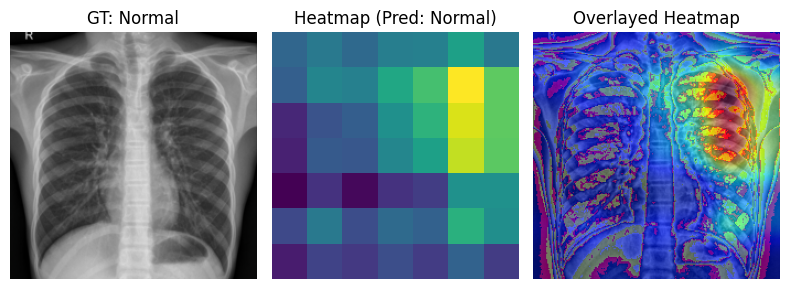

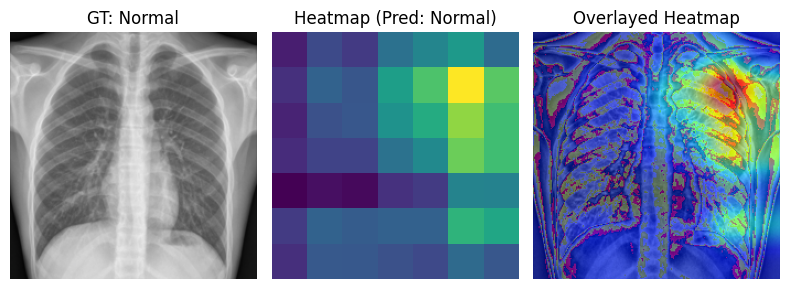

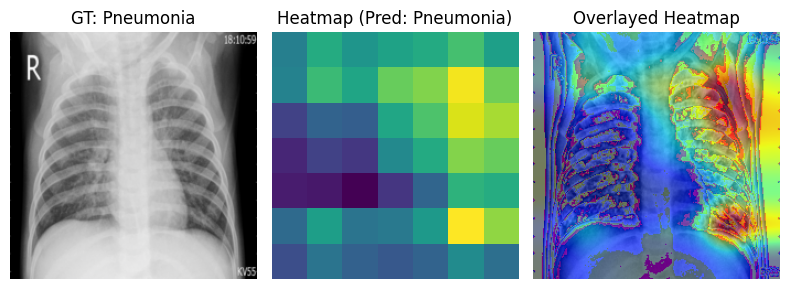

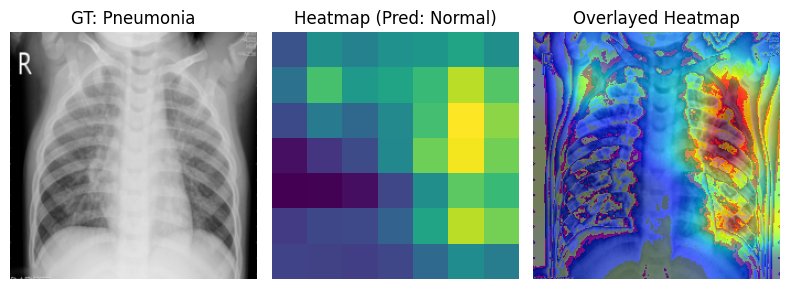

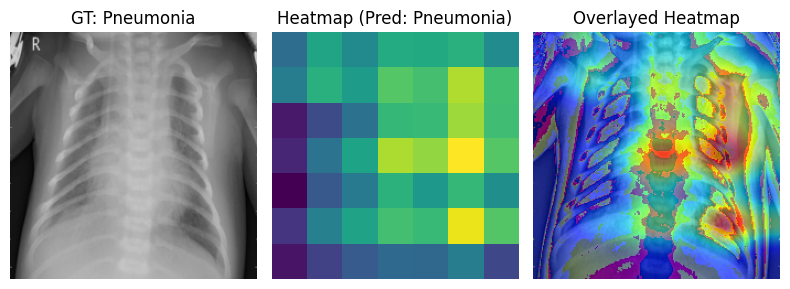

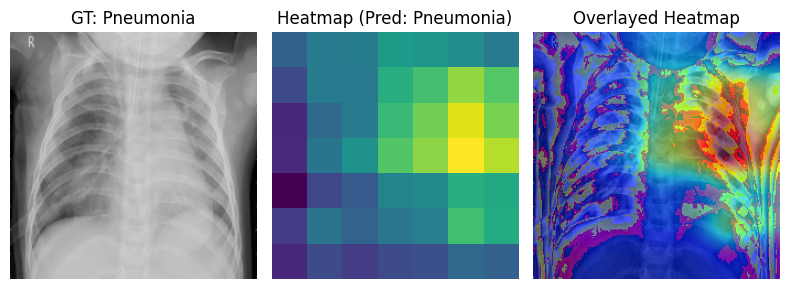

In [62]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18, vgg16
from torchcam.methods import SmoothGradCAMpp, CAM, LayerCAM, GradCAM
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask


# function to plot img, feature_map
def plot_activation_with_cam(orig_img, label, pred, activation_map, cam_img):
    plt.figure(figsize=(8, 6))

    # subplot titles
    titles = [f"GT: {label_to_class[label]}", f"Heatmap (Pred: {label_to_class[pred]})", "Overlayed Heatmap"]

    for i, (img, title) in enumerate(zip([np.clip(orig_img.permute(1, 2, 0).cpu().numpy()*std + mean, 0, 1),
                                          activation_map[0].squeeze(0),
                                          cam_img],
                                         titles), start=1):
        plt.subplot(1, 3, i)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# compute GRAD-CAM for each image
for i, (img, lbl) in enumerate(cam_dataset):
    with SmoothGradCAMpp(model_new, target_layer='layer4') as cam_extractor:
        # Preprocess your data and feed it to the model
        out = model_new(img.unsqueeze(0))
        pred = (torch.sigmoid(out.squeeze(0)) > threshold).int().item()

        # Retrieve the CAM by passing the class index and the model output
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

        # Resize the CAM and overlay it
        result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

        # Display it
        plot_activation_with_cam(img, lbl, pred, activation_map, result)